In [1]:
import mindspore
mindspore.set_context(device_target='GPU')
mindspore.run_check()

[WARNING] ME(3337510:140635541296192,MainProcess):2023-12-21-16:54:50.236.522 [mindspore/run_check/_check_version.py:102] MindSpore version 2.0.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


MindSpore version:  2.0.0
The result of multiplication calculation is correct, MindSpore has been installed on platform [GPU] successfully!


**Dataset**
we implement GoogleNet on CIFAR10 dataset which can be downloaded using *download* api. It can be installed by using the command pip install download

In [2]:
# Download data from open datasets\n",
from download import download

url = "http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz"
path = download(url, "./", kind="tar.gz", replace=True)


file_sizes: 100%|████████████████████████████| 170M/170M [01:06<00:00, 2.56MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./


In [3]:
index2label={}
with open('./cifar-10-batches-bin/batches.meta.txt','r') as fp:
    lines = fp.readlines()
    for index,line in enumerate(lines):
        line = line.strip('\n')
        if line:
            index2label[index]=line
index2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Then, the mindspore.dataset.Cifar10Dataset interface is used to load the dataset and perform the associated image transforms.

In [4]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from mindspore import dtype as mstype

data_dir = "./cifar-10-batches-bin"  # Root directory of the dataset
batch_size = 64  # Batch size
image_size = 224  # Image size of training data
workers = 4  # Number of parallel workers
num_classes = 10  # Number of classes


def create_dataset_cifar10(dataset_dir, usage, resize, batch_size, workers):

    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir,
                                 usage=usage,
                                 num_parallel_workers=workers,
                                 shuffle=True)

    trans = []
    if usage == "train":
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    target_trans = transforms.TypeCast(mstype.int32)

    # Data transformation
    data_set = data_set.map(operations=trans,
                            input_columns='image',
                            num_parallel_workers=workers)

    data_set = data_set.map(operations=target_trans,
                            input_columns='label',
                            num_parallel_workers=workers)

    # Batching
    data_set = data_set.batch(batch_size)
    data_set = data_set.repeat(2)

    return data_set


# Obtain the preprocessed training and testing datasets

dataset_train = create_dataset_cifar10(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_cifar10(dataset_dir=data_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()


In [5]:
step_size_train

1564

Visualize the CIFAR-10 training dataset.

Image shape: (64, 3, 224, 224), Label shape: (64,)
Labels: [2 6 7 8 9 9]


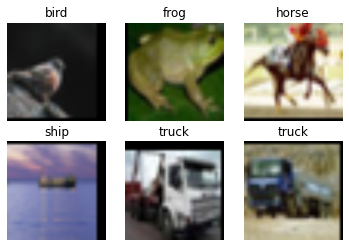

In [6]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

# The labels for the first six pictures in the training dataset
print(f"Labels: {labels[:6]}")

classes = []

with open(data_dir + "/batches.meta.txt", "r") as f:
    for line in f:
        line = line.rstrip()
        if line:
            classes.append(line)

# First six pictures in the training dataset
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()


Building a Network

Inception

In [7]:
from typing import Type, Union, List, Optional
import mindspore.nn as nn
from mindspore.common.initializer import Normal,TruncatedNormal

# Initialize the parameters of the convolutional layer and BatchNorm layer
weight_init = TruncatedNormal()
gamma_init = Normal(mean=1, sigma=0.02)

In [8]:
class Conv2dBlock(nn.Cell):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, pad_mode="same"):
        super(Conv2dBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                              padding=padding, pad_mode=pad_mode, weight_init=weight_init)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.ReLU()

    def construct(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

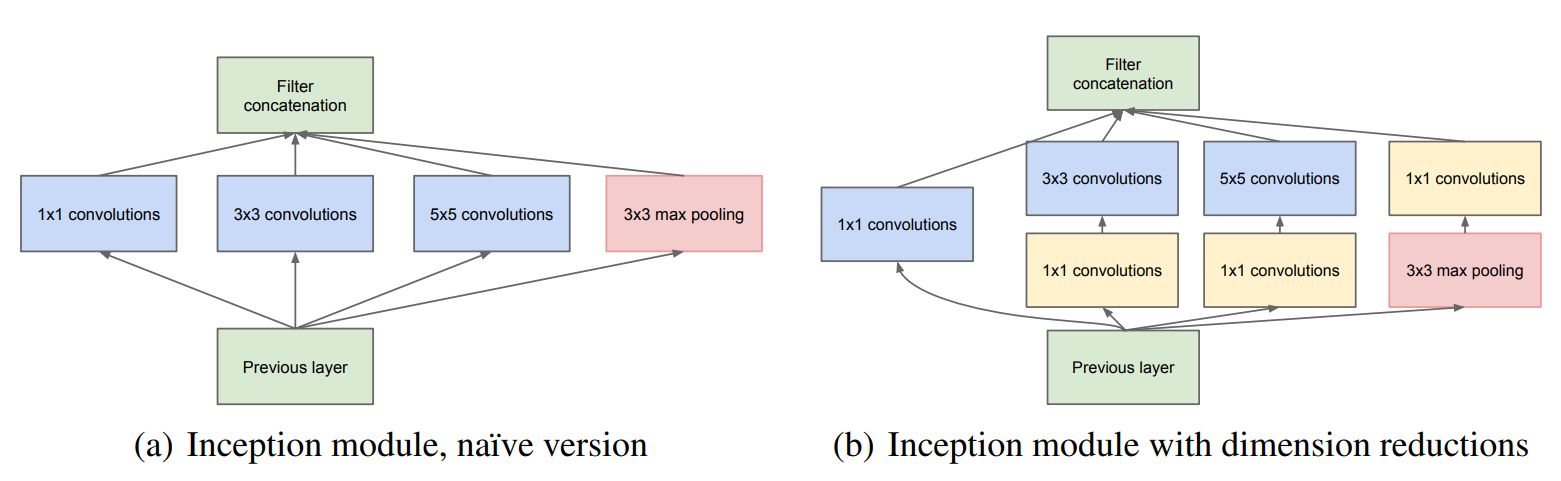

In [9]:
from mindspore import ops
class Inception(nn.Cell):
    """
    Inception Block
    """

    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.b1 = Conv2dBlock(in_channels, n1x1, kernel_size=1)
        self.b2 = nn.SequentialCell([Conv2dBlock(in_channels, n3x3red, kernel_size=1),
                                     Conv2dBlock(n3x3red, n3x3, kernel_size=3, padding=0)])
        self.b3 = nn.SequentialCell([Conv2dBlock(in_channels, n5x5red, kernel_size=1),
                                     Conv2dBlock(n5x5red, n5x5, kernel_size=3, padding=0)])
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, pad_mode="same")
        self.b4 = Conv2dBlock(in_channels, pool_planes, kernel_size=1)
        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        branch1 = self.b1(x)
        branch2 = self.b2(x)
        branch3 = self.b3(x)
        cell = self.maxpool(x)
        branch4 = self.b4(cell)
        return self.concat((branch1, branch2, branch3, branch4))

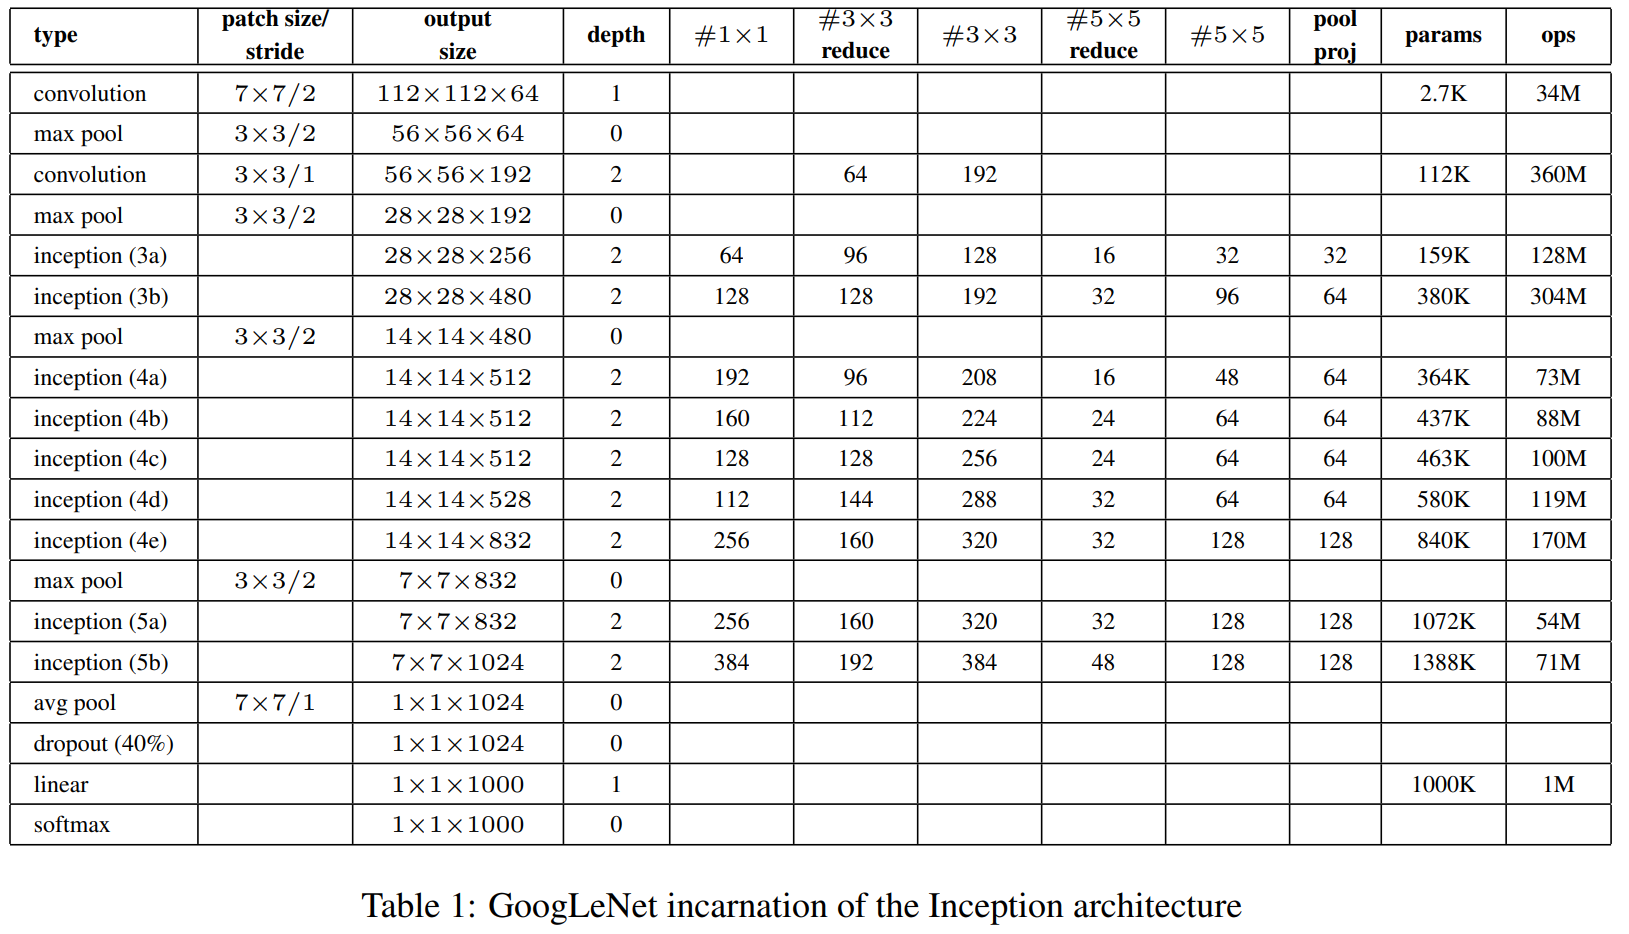

In [10]:
class GoogleNet(nn.Cell):
    """
    Googlenet architecture
    """

    def __init__(self, num_classes, include_top=True):
        super(GoogleNet, self).__init__()
        self.conv1 = Conv2dBlock(3, 64, kernel_size=7, stride=2, padding=0) # 7*7 卷积层
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same") # 3*3 最大池化层

        self.conv2 = Conv2dBlock(64, 64, kernel_size=1) # 1*1 卷积层
        self.conv3 = Conv2dBlock(64, 192, kernel_size=3, padding=0) # 3*3 卷积层
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same") # 3*3 最大池化层

        self.block3a = Inception(192, 64, 96, 128, 16, 32, 32) 
        self.block3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same") # 3*3 最大池化层

        self.block4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.block4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.block4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.block4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.block4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same") # 3*3 最大池化层

        self.block5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.block5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.dropout = nn.Dropout(keep_prob=0.4)
        self.include_top = include_top
        if self.include_top:
            self.mean = ops.ReduceMean(keep_dims=True)
            self.flatten = nn.Flatten()
            self.classifier = nn.Dense(1024, num_classes, weight_init=weight_init,
                                       bias_init=weight_init)


    def construct(self, x):
        """construct"""
        x = self.conv1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.block3a(x)
        x = self.block3b(x)
        x = self.maxpool3(x)

        x = self.block4a(x)
        x = self.block4b(x)
        x = self.block4c(x)
        x = self.block4d(x)
        x = self.block4e(x)
        x = self.maxpool4(x)

        x = self.block5a(x)
        x = self.block5b(x)
        if not self.include_top:
            return x

        x = self.mean(x, (2, 3))
        x = self.flatten(x)
        x = self.classifier(x)

        return x

Model Training and Evaluation

In [11]:
network = GoogleNet(num_classes=10)
network

[WARNING] ME(3337510:140635541296192,MainProcess):2023-12-21-17:00:28.169.764 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(3337510:140635541296192,MainProcess):2023-12-21-17:00:28.172.775 [mindspore/nn/layer/basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


GoogleNet<
  (conv1): Conv2dBlock<
    (conv): Conv2d<input_channels=3, output_channels=64, kernel_size=(7, 7), stride=(2, 2), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x7fe7fc74dc90>, bias_init=zeros, format=NCHW>
    (bn): BatchNorm2d<num_features=64, eps=0.001, momentum=0.9, gamma=Parameter (name=conv1.bn.gamma, shape=(64,), dtype=Float32, requires_grad=True), beta=Parameter (name=conv1.bn.beta, shape=(64,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=conv1.bn.moving_mean, shape=(64,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=conv1.bn.moving_variance, shape=(64,), dtype=Float32, requires_grad=False)>
    (relu): ReLU<>
    >
  (maxpool1): MaxPool2d<kernel_size=3, stride=2, pad_mode=SAME>
  (conv2): Conv2dBlock<
    (conv): Conv2d<input_channels=64, output_channels=64, kernel_size=(1, 1), stride=(1, 1), pad_mode=same, padding=0, dilation=(1, 1

In [12]:
# Set the learning rate
num_epochs = 100
lr = nn.exponential_decay_lr(0.1, 0.6, total_step=step_size_train * num_epochs,
                        step_per_epoch=num_epochs, decay_epoch=90)
# Define optimizer and loss function
opt = nn.Momentum(filter(lambda x: x.requires_grad, network.get_parameters()), learning_rate=lr, momentum=0.9, weight_decay=0.0005)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


def forward_fn(inputs, targets):
    logits = network(inputs)
    loss = loss_fn(logits, targets)
    return loss


grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)


def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss


In [13]:
import os

# Creating Iterators
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# Optimal model storage path
best_acc = 0
best_ckpt_dir = "./Checkpoint"
best_ckpt_path = "./Checkpoint/GoogleNet.ckpt"

if not os.path.exists(best_ckpt_dir):
    os.mkdir(best_ckpt_dir)

In [14]:
def train(data_loader, epoch):
    """Model taining"""
    losses = []
    network.set_train(True)

    for i, (images, labels) in enumerate(data_loader):
        loss = train_step(images, labels)
        if i % 100 == 0 or i == step_size_train - 1:
            print('Epoch: [%3d/%3d], Steps: [%3d/%3d], Train Loss: [%5.3f]' %
                  (epoch + 1, num_epochs, i + 1, step_size_train, loss))
        losses.append(loss)

    return sum(losses) / len(losses)


def evaluate(data_loader):
    """Model Evaluation"""
    network.set_train(False)

    correct_num = 0.0  # Number of correct predictions
    total_num = 0.0  # Total number of predictions

    for images, labels in data_loader:
        logits = network(images)
        pred = logits.argmax(axis=1)  # Prediction results
        correct = ops.equal(pred, labels).reshape((-1, ))
        correct_num += correct.sum().asnumpy()
        total_num += correct.shape[0]

    acc = correct_num / total_num  # Accuracy

    return acc

In [15]:
# Start training loop
print("Start Training Loop ...")

for epoch in range(num_epochs):
    curr_loss = train(data_loader_train, epoch)
    curr_acc = evaluate(data_loader_val)

    print("-" * 50)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
        epoch+1, num_epochs, curr_loss, curr_acc
    ))
    print("-" * 50)

    # Save the model that has achieved the highest prediction accuracy
    if curr_acc > best_acc:
        best_acc = curr_acc
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Start Training Loop ...
Epoch: [  1/100], Steps: [  1/1564], Train Loss: [2.341]
Epoch: [  1/100], Steps: [101/1564], Train Loss: [2.229]
Epoch: [  1/100], Steps: [201/1564], Train Loss: [1.981]
Epoch: [  1/100], Steps: [301/1564], Train Loss: [1.935]
Epoch: [  1/100], Steps: [401/1564], Train Loss: [1.853]
Epoch: [  1/100], Steps: [501/1564], Train Loss: [1.678]
Epoch: [  1/100], Steps: [601/1564], Train Loss: [1.676]
Epoch: [  1/100], Steps: [701/1564], Train Loss: [1.915]
Epoch: [  1/100], Steps: [801/1564], Train Loss: [1.710]
Epoch: [  1/100], Steps: [901/1564], Train Loss: [1.333]
Epoch: [  1/100], Steps: [1001/1564], Train Loss: [1.695]
Epoch: [  1/100], Steps: [1101/1564], Train Loss: [1.575]
Epoch: [  1/100], Steps: [1201/1564], Train Loss: [1.482]
Epoch: [  1/100], Steps: [1301/1564], Train Loss: [1.242]
Epoch: [  1/100], Steps: [1401/1564], Train Loss: [1.299]
Epoch: [  1/100], Steps: [1501/1564], Train Loss: [1.203]
Epoch: [  1/100], Steps: [1564/1564], Train Loss: [1.285]


[WARNING] ME(3337510:140635541296192,MainProcess):2023-12-21-22:51:16.706.125 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


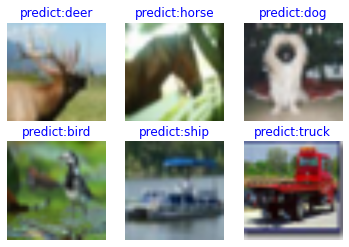

In [16]:
import matplotlib.pyplot as plt


def visualize_model(best_ckpt_path, dataset_val):
    num_class = 10  # Perform binary classification on wolf and dog images.
    net = GoogleNet(num_class)
    # Load model parameters.
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    # Load the validation dataset.
    data = next(dataset_val.create_dict_iterator())
    images = data["image"]
    labels = data["label"]
    # Predict the image type.
    output = net(data['image'])
    pred = np.argmax(output.asnumpy(), axis=1)

    # Image classification
    classes = []

    with open(data_dir + "/batches.meta.txt", "r") as f:
        for line in f:
            line = line.rstrip()
            if line:
                classes.append(line)

    # Show the picture along with its corresponding predicted value.
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        # If the prediction is correct, it will appear in blue; otherwise, it will show up in red.
        color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
        plt.title('predict:{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


# Validate with test dataset
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)
